# Notebook ML Word2Vec and Doc2Vec

Toutes les sections avant la partie `Word2Vec` sont issues du Notebook : `Notebook_ML_Count-TFIDF_Chi2`. Elles sont donc volontairement moins détaillées pour éviter la redondance (l'explication complète est donnée dans ce Notebook).  

Les parties `Word2Vec` et `Doc2Vec` sont tirées de la ressource : https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568.

## Acquisition et prétraitement des données

In [1]:
## for data
import json
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection

## machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from itertools import islice
from gensim import matutils

## Doc2Vec
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim 
from gensim.models.doc2vec import TaggedDocument

## Image
from IPython.display import Image


import sklearn.metrics as metrics
import seaborn as sns

data = pd.read_json('../Data/data.json')
category = pd.read_csv('../Data/categories_string.csv')
label = pd.read_csv('../Data/label.csv')


#### Création d'une nouvelle colonne correspondant à l'id de la catégorie de poste

In [2]:
data = pd.merge(data, label, how="right", on="Id")

#### Récupération d'une partie des données

In [3]:
# data, data_other_part, y_studied_part, y_other_part = train_test_split(data, data["Category"], train_size=0.1, random_state=211101)

Vérification de la distribution des données.

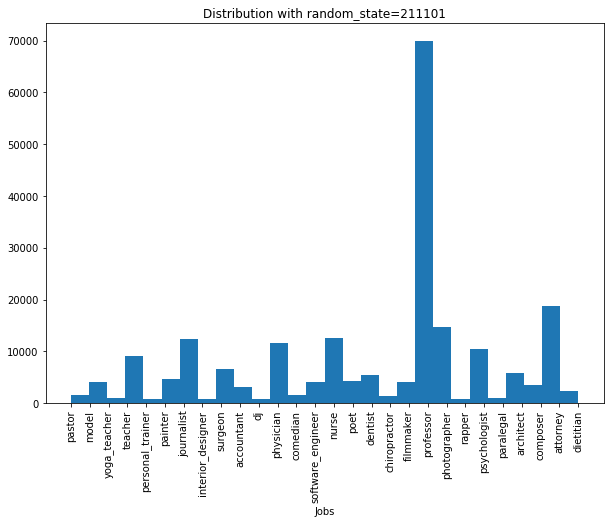

In [4]:
plt.figure(figsize=(10, 7))
plt.hist(data['Category'], 28)
plt.title("Distribution with random_state=211101")
plt.xlabel("Jobs")
plt.xticks(ticks = range(28), labels = category['0'], rotation = 'vertical')
plt.show()

#### Préprocessing des extraits de CV

Méthode permettant le préprocessing des extraits de CV. Le principe est le même qu'avec les précédents Notebook. Cependant, cette fois, la casse est préservée, car le vocabulaire distingue les majuscules et minuscules.

In [5]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, number=False, lst_stopwords=None):
    ## clean (remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).strip())
    
    ## remove number
    if not number:
        text = re.sub('[0-9]+', '', text)
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.SnowballStemmer("english")
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [6]:
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Appliquer la fonction à la liste des extraits de CV.

In [7]:
nltk.download('wordnet')
data_clean = data
data_clean["description_clean"] = data_clean["description"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, number=True, lst_stopwords=lst_stopwords))

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Fonctions utiles pour l'affichage de la précision des modèles

In [8]:
def train_and_display_pipeline_results(model_grid, X_train, y_train, X_test, y_test):
    print('Train Accuracy Best Estimator : ', model_grid.best_estimator_.score(X_train, y_train))
    print('Test Accuracy Best Estimator : ', model_grid.best_estimator_.score(X_test, y_test))
    print('Best Accuracy Through Grid Search : ', model_grid.best_score_)
    print('Best Parameters : ',model_grid.best_params_)

In [9]:
'''
Affichage des résultats du modèle entrainé
:parameter
    :param model: Le modèle entrainé
    :param X_train: Le dataset d'entrée train
    :param y_train: Le dataset de sortie train
    :param X_test: Le dataset d'entrée test
    :param y_test: Le dataset de sortie train
'''
def display_stats_model_trained(model, X_train, y_train, X_test, y_test, display_graphics):

    ## Accuracy train and test, Precision, Recall
    #auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy:")
    print("\rTrain: ", model.score(X_train, y_train))
    print("\rTest: ", model.score(X_test, y_test))
    #print("Area under the curve (Auc): ", auc)
    print("")
    
    # Get predictions
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    if display_graphics == True:
        # Get dataset test categories
        classes = np.unique(y_test)
        y_test_array = pd.get_dummies(y_test, drop_first=False).values
        print("Detail:")
        print(metrics.classification_report(y_test, predicted))

        ## Plot confusion matrix
        cm = metrics.confusion_matrix(y_test, predicted)
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
        ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
        plt.yticks(rotation=0)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
            ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
        ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
        ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
                  xlabel='False Positive Rate', 
                  ylabel="True Positive Rate (Recall)", 
                  title="Receiver operating characteristic")
        ax[0].legend(loc="lower right")
        ax[0].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = metrics.precision_recall_curve(
                         y_test_array[:,i], predicted_prob[:,i])
            ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i],  metrics.auc(recall, precision)))
        ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
        ax[1].legend(loc="best")
        ax[1].grid(True)
        plt.show()

## Utilisation de Word2Vec

Tout d'abord, on charge le model Word2Vec. Il a été pré-formé par Google sur un **corpus Google News de 100 milliards de mots**.

In [10]:
wv = KeyedVectors.load_word2vec_format('../Data/GoogleNews-vectors-negative300.bin.gz', binary=True)
wv.init_sims(replace=True)

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

On affiche une partie du vocabulaire et on constate que chaque mot est représenté sous forme de vecteur.

In [12]:
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

### Déclaration des fonctions de traitement des extraits de CV (average, tokenization)

On utilise une fonction qui permet de faire la moyenne des vecteurs de mots correspondant à un extrait de cv.

In [13]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    # For each word in the cv extract
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    mean = matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32) 
    return mean

L'image suivante est tiré du github : https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb.  
Elle permet d'expliquer l'objectif de la précédente méthode.

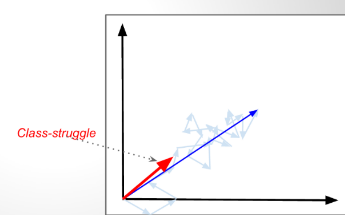

In [14]:
Image(url='https://github.com/RaRe-Technologies/movie-plots-by-genre/raw/9e9f3479f928c9eb39f08b9915a858d327e22d27/ipynb_with_output/images/naivedoc2vec.png', embed=True)

Fonction qui réalise la moyenne des vecteurs de mots pour tous les extraits de CV du dataset.

In [15]:
def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, cv_extract) for cv_extract in text_list ])

Fonction permmettant la *tokenization* des extraits de CV.

In [16]:
def w2v_tokenize_text(text):
    tokens = []
    # For each sentence in the text
    for sent in nltk.sent_tokenize(text, language='english'):
        # For each words in the text
        for word in nltk.word_tokenize(sent, language='english'):
            # Delete words composed of 2 letters
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

En effet, on s'aperçoit bien de l'objectif de la *tokenization*, avec les lignes de code suivantes.

In [17]:
sentence = nltk.sent_tokenize("The cat sat on the mat. The cat sat on the mat.", language='english')
print(sentence)
words = nltk.word_tokenize(sentence[0], language='english')
print(words)

['The cat sat on the mat.', 'The cat sat on the mat.']
['The', 'cat', 'sat', 'on', 'the', 'mat', '.']


### Séparation du dataset en train et test

In [18]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=211101)

### Application des fonctions de traitement précédentes sur le dataset

On commence d'abord par la *tokenization*, puis par l'*averaging*.

In [19]:
test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['description_clean']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['description_clean']), axis=1).values

In [20]:
X_train_word_average = word_averaging_list(wv, train_tokenized)
X_test_word_average = word_averaging_list(wv, test_tokenized)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  if __name__ == '__main__':


### Entrainement du modèle avec le classifier Logistic Regression

On réalise une classification avec l'hyperparamètre `C` faible (inverse de la pénalisation) car on s'est aperçu dans les précédant Notebooks que les algorithmes avaient tendance à overfitter sur ce dataset.

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy:
Train:  0.7730336044015493
Test:  0.76597605893186

Detail:
              precision    recall  f1-score   support

           0       0.59      0.49      0.53       297
           1       0.76      0.71      0.73       811
           2       0.74      0.70      0.72       210
           3       0.58      0.50      0.54      1851
           4       0.76      0.68      0.72       155
           5       0.75      0.75      0.75       960
           6       0.67      0.70      0.69      2448
           7       0.62      0.53      0.57       160
           8       0.79      0.66      0.72      1340
           9       0.75      0.67      0.71       575
          10       0.77      0.62      0.68       185
          11       0.68      0.62      0.65      2236
          12       0.77      0.73      0.75       320
          13       0.71      0.62      0.66       810
          14       0.80      0.79      0.80      2572
          15       0.68      0.65      0.67       828
          1

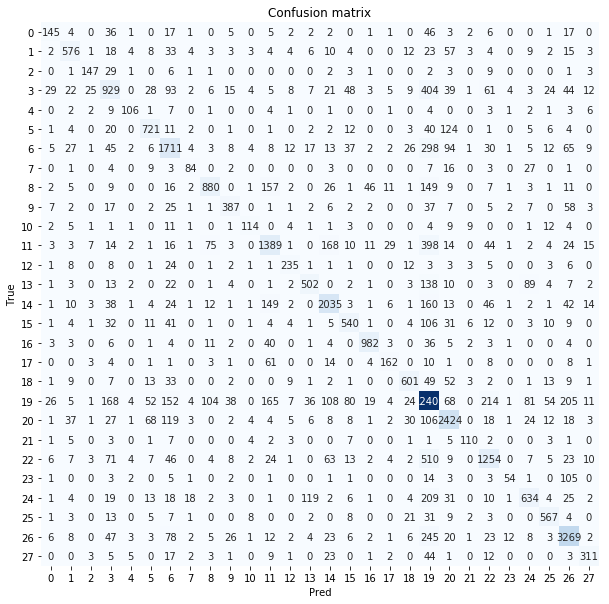

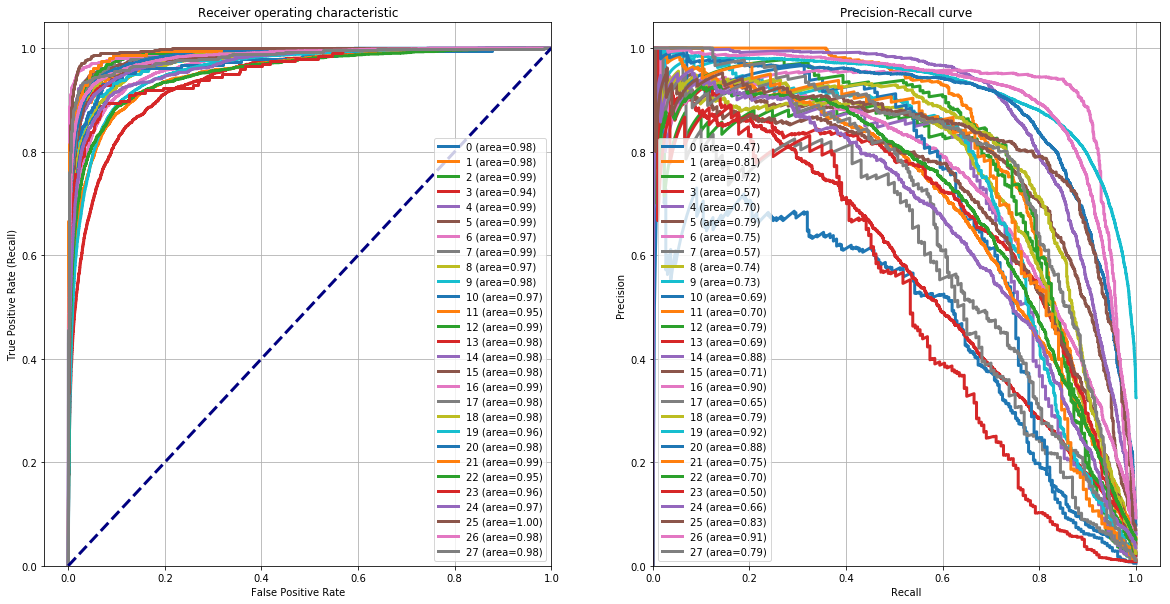

In [21]:
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg.fit(X_train_word_average, train['Category'])

display_stats_model_trained(logreg, X_train_word_average, train['Category'], X_test_word_average, test['Category'], True)

### Entrainement du modèle avec le classifier Neural Network

Pour la première tentative d'entraînement, on reprend les mêmes hyperparamètres qu'avec le Notebook : `Notebook_ML_Count-TFIDF_Chi2` pour lesquels le NN avait la meilleure précision.

Accuracy:
Train:  0.7841871118861399
Test:  0.7731813996316759

Detail:
              precision    recall  f1-score   support

           0       0.55      0.53      0.54       297
           1       0.76      0.73      0.75       811
           2       0.75      0.64      0.69       210
           3       0.57      0.52      0.55      1851
           4       0.66      0.67      0.66       155
           5       0.74      0.74      0.74       960
           6       0.67      0.71      0.69      2448
           7       0.67      0.48      0.56       160
           8       0.76      0.67      0.71      1340
           9       0.76      0.66      0.71       575
          10       0.73      0.61      0.67       185
          11       0.68      0.65      0.66      2236
          12       0.75      0.68      0.71       320
          13       0.67      0.62      0.65       810
          14       0.82      0.79      0.80      2572
          15       0.67      0.69      0.68       828
         

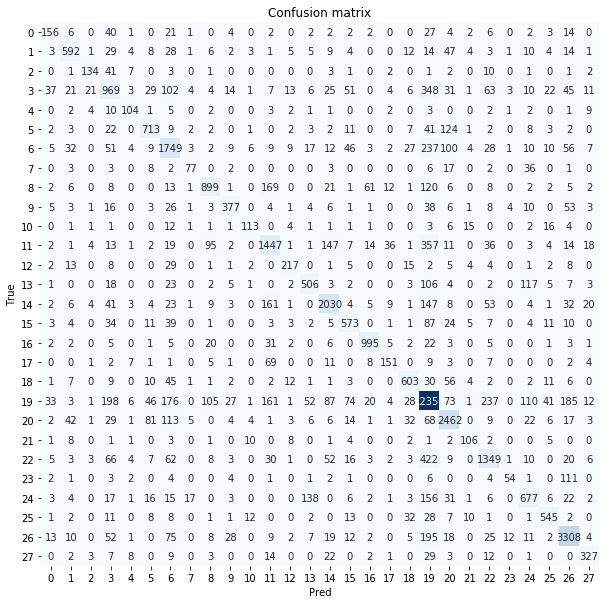

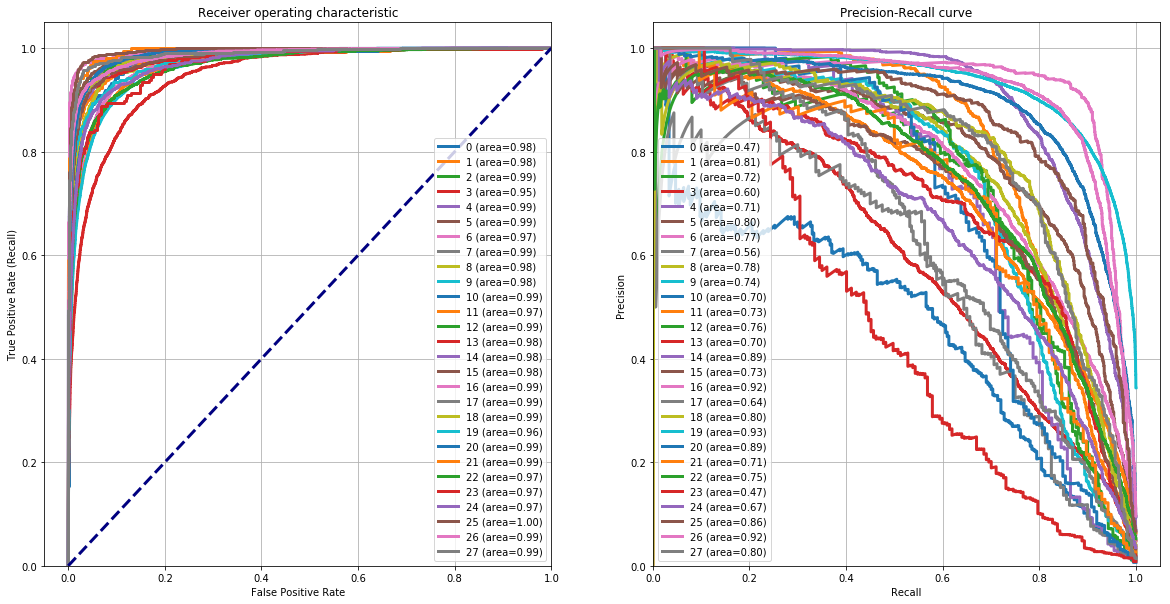

In [24]:
nn_classifier = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(30), alpha=1, activation="relu", max_iter=5000, random_state=0)
nn_classifier.fit(X_train_word_average, train['Category'])

display_stats_model_trained(nn_classifier, X_train_word_average, train['Category'], X_test_word_average, test['Category'], True)

In [21]:
nn_classifier= MLPClassifier(solver="lbfgs", hidden_layer_sizes=(40), alpha=5, activation="relu", max_iter=1000, random_state=0)
nn_classifier.fit(X_train_word_average, train['Category'])

display_stats_model_trained(nn_classifier, X_train_word_average, train['Category'], X_test_word_average, test['Category'], False)

Accuracy:
Train:  0.7843540116369413
Test:  0.7738720073664825



A noter que si l'on augmente le nombre de layers, le résultat obtenu devient moins précis.

### Entrainement du modèle avec le classifier Random Forest

De la même manière, on reprend les mêmes hyperparamètres qu'avec le Notebook : `Notebook_ML_Count-TFIDF_Chi2` pour lesquels le Random Forest avait la meilleure précision.

Accuracy:
Train:  0.9999424483617926
Test:  0.6741252302025783

Detail:
              precision    recall  f1-score   support

           0       0.70      0.09      0.17       297
           1       0.90      0.54      0.68       811
           2       0.86      0.38      0.53       210
           3       0.50      0.32      0.39      1851
           4       0.92      0.22      0.35       155
           5       0.85      0.38      0.53       960
           6       0.56      0.55      0.56      2448
           7       1.00      0.03      0.05       160
           8       0.82      0.58      0.68      1340
           9       0.96      0.27      0.42       575
          10       0.90      0.33      0.48       185
          11       0.70      0.54      0.61      2236
          12       0.89      0.47      0.61       320
          13       0.73      0.37      0.49       810
          14       0.85      0.69      0.76      2572
          15       0.72      0.31      0.43       828
         

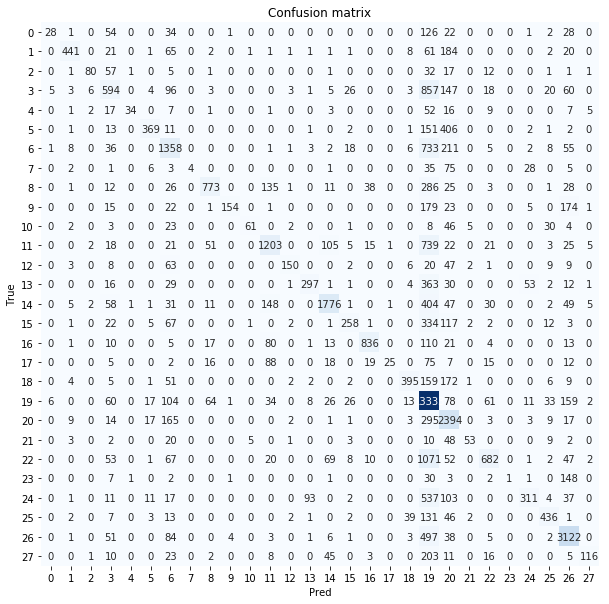

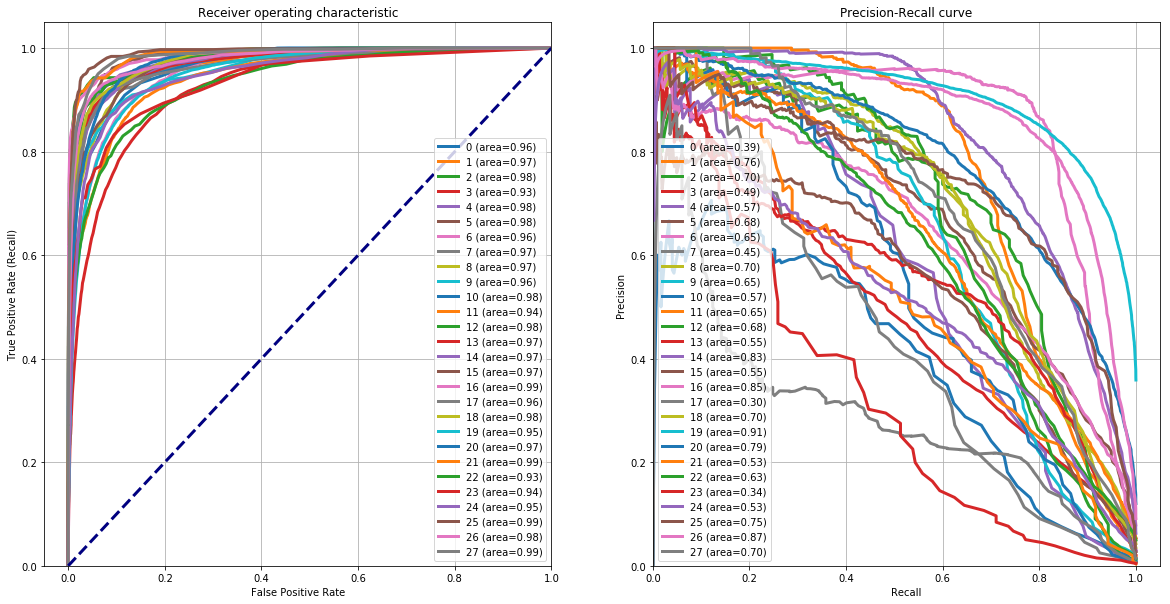

In [22]:
random_forest = RandomForestClassifier(max_depth=500, max_features='sqrt', n_estimators= 500)
random_forest.fit(X_train_word_average, train['Category'])

display_stats_model_trained(random_forest, X_train_word_average, train['Category'], X_test_word_average, test['Category'], True)

### Conclusion Word2Vec

Les modèles entraînés ont des résultats très encourageants.  

Pour le classifier **Regression Logistic**, on obtient un score pour le test de `0.765` et une vitesse d'entraînement  correcte.  

Le classifier **Neural Network** permet d'obtenir une précision légèrement supérieure à `0.773` : ce pallier représente le score le plus élevé jusqu'à présent. Il est un peu plus long à entraîner que le classifier précédent, mais il ne présente pas d'overfitting comme dans le notebook `Notebook_ML_Count-TFIDF_Chi2`.  

Enfin, le classifier **Random Forest** possède une précision d'environ 10 points de moins que les deux autres et présente de l'overfitting.

## Utilisation de Doc2vec

Pour cette partie, nous ne sommes pas rentrés dans les détails du principe de fonctionnement de `Doc2Vec` : nous avons principalement appliqué les recommandations de l'auteur notamment pour les hyperparamètres de la méthode `Doc2Vec`.  

Pour l'entraînement  des modèles, nous avons repris les mêmes types d'algorithmes, ainsi que les hyperparamètres associés (sauf pour le maximum d'itérations). En effet, la méthode `Doc2Vec` est présentée comme assez proche de `Word2Vec`.

In [23]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled


X_train, X_test, y_train, y_test = train_test_split(data_clean['description_clean'], data_clean["Category"], random_state=211101, test_size=0.2)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

Récupération du modèle Doc2Vec.

In [24]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 217197/217197 [00:00<00:00, 1125148.82it/s]


Permet d'obtenir les vecteurs en fonction du modèle Doc2Vec.

In [25]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [26]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

### Entrainement du modèle avec le classifier Logistic Regression

In [28]:
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter=2000)
logreg.fit(train_vectors_dbow, y_train)

display_stats_model_trained(logreg, train_vectors_dbow, y_train, test_vectors_dbow, y_test, False)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy:
Train:  0.7713876275488182
Test:  0.7649861878453039



### Entrainement du modèle avec le classifier Neural Network

Accuracy:
Train:  0.7930443090062559
Test:  0.7737338858195212

Detail:
              precision    recall  f1-score   support

           0       0.52      0.53      0.53       297
           1       0.74      0.70      0.72       811
           2       0.67      0.59      0.63       210
           3       0.57      0.51      0.54      1851
           4       0.55      0.56      0.56       155
           5       0.76      0.75      0.75       960
           6       0.67      0.72      0.70      2448
           7       0.65      0.45      0.53       160
           8       0.76      0.68      0.72      1340
           9       0.74      0.67      0.71       575
          10       0.72      0.48      0.57       185
          11       0.66      0.62      0.64      2236
          12       0.73      0.65      0.69       320
          13       0.64      0.67      0.66       810
          14       0.81      0.81      0.81      2572
          15       0.68      0.72      0.70       828
         

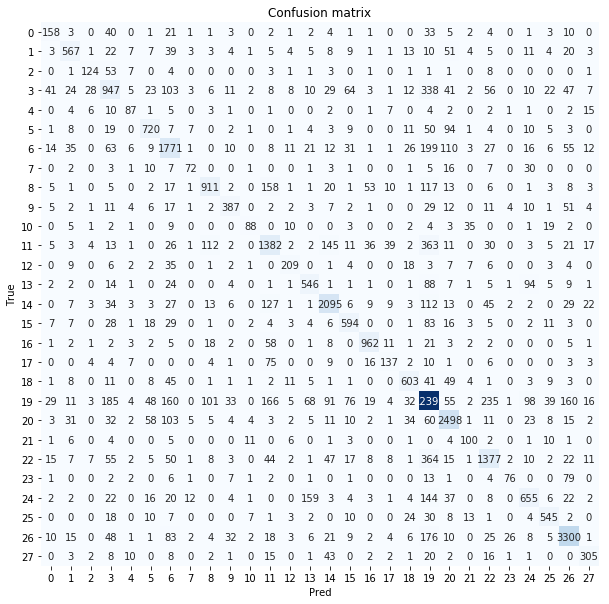

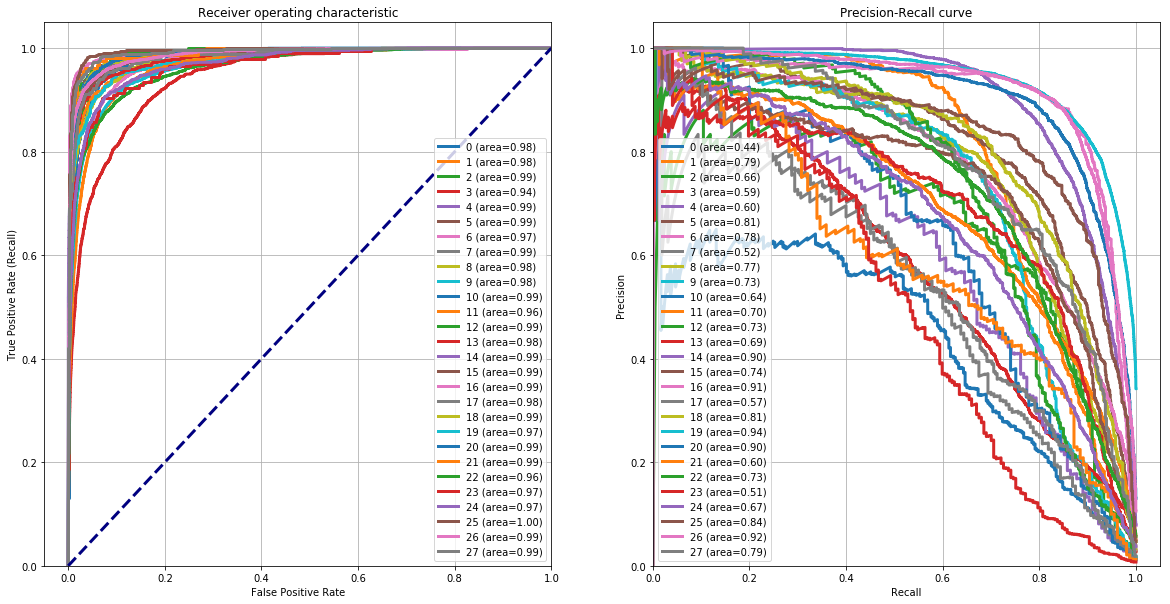

In [29]:
nn_classifier = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(30), alpha=1, activation="relu", max_iter=5000, random_state=0)
nn_classifier.fit(train_vectors_dbow, y_train)

display_stats_model_trained(nn_classifier, train_vectors_dbow, y_train, test_vectors_dbow, y_test, True)

Accuracy:
Train:  0.8032539696242453
Test:  0.7773250460405157

Detail:
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       297
           1       0.75      0.71      0.73       811
           2       0.71      0.64      0.68       210
           3       0.56      0.52      0.54      1851
           4       0.66      0.68      0.67       155
           5       0.76      0.75      0.75       960
           6       0.68      0.72      0.70      2448
           7       0.60      0.50      0.55       160
           8       0.75      0.68      0.71      1340
           9       0.73      0.68      0.71       575
          10       0.71      0.55      0.62       185
          11       0.67      0.64      0.65      2236
          12       0.70      0.69      0.69       320
          13       0.67      0.69      0.68       810
          14       0.82      0.80      0.81      2572
          15       0.68      0.72      0.70       828
         

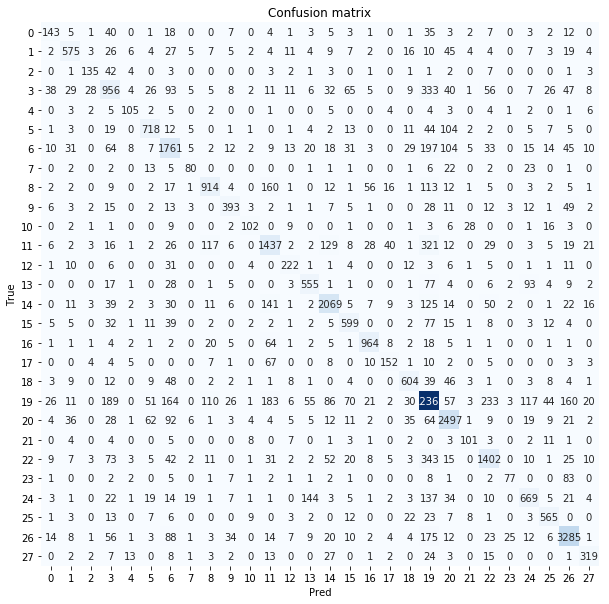

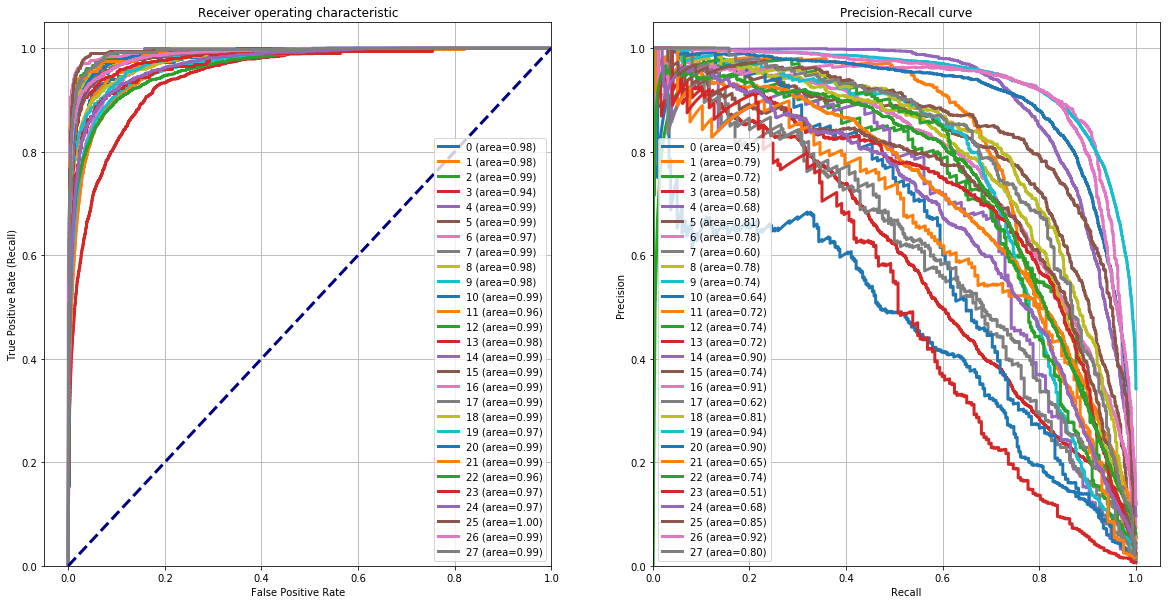

In [30]:
nn_classifier= MLPClassifier(solver="lbfgs", hidden_layer_sizes=(40), alpha=5, activation="relu", max_iter=1000, random_state=0)
nn_classifier.fit(train_vectors_dbow, y_train)

display_stats_model_trained(nn_classifier, train_vectors_dbow, y_train, test_vectors_dbow, y_test, True)

### Entrainement du modèle avec le classifier Random Forest

Accuracy:
Train:  1.0
Test:  0.5429558011049723

Detail:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       297
           1       0.97      0.35      0.52       811
           2       0.00      0.00      0.00       210
           3       0.54      0.05      0.08      1851
           4       0.00      0.00      0.00       155
           5       1.00      0.01      0.02       960
           6       0.61      0.28      0.38      2448
           7       0.00      0.00      0.00       160
           8       0.91      0.32      0.48      1340
           9       1.00      0.02      0.03       575
          10       0.00      0.00      0.00       185
          11       0.69      0.46      0.56      2236
          12       1.00      0.00      0.01       320
          13       0.88      0.05      0.09       810
          14       0.82      0.57      0.68      2572
          15       0.83      0.01      0.01       828
          16       0.90 

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


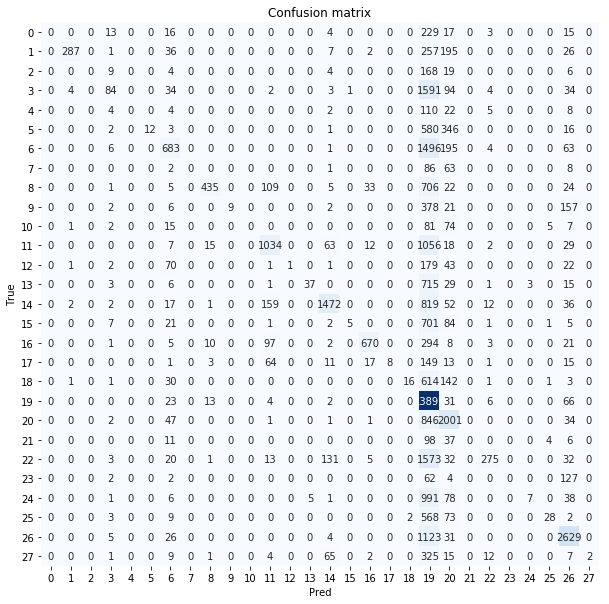

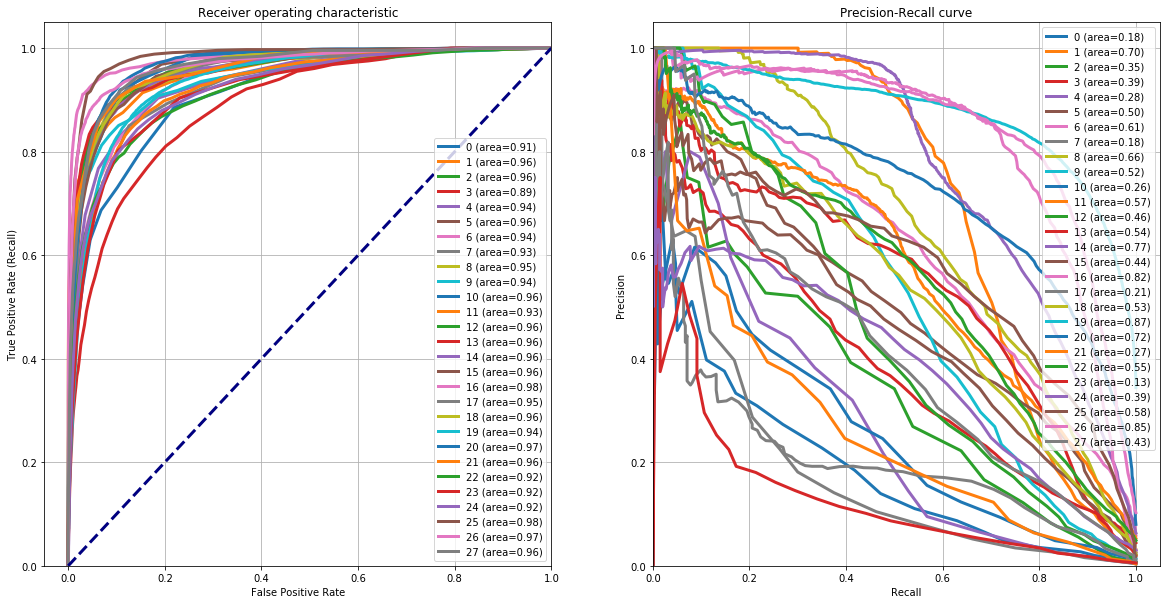

In [31]:
random_forest = RandomForestClassifier(max_depth=500, max_features='sqrt', n_estimators= 500)
random_forest.fit(train_vectors_dbow, y_train)

display_stats_model_trained(random_forest, train_vectors_dbow, y_train, test_vectors_dbow, y_test, True)

### Conclusion Doc2Vec

Les résultats obtenus sont sensiblement les mêmes que pour la partie `Word2Vec`.  

Pour le classifier **Regression Logistic**, le score de test est de `0.77`.  

Le classifier **Neural Network** permet d'atteindre quasiment une précision de `0.78` sans overfitter.  

Cependant, le classifier **Random Forest** propose un score plus faible que précédemment et accentue le problème d'overfitting.

## Conclusion

Pour conclure, les classifiers **Regression Logistic** et **Neural Network** associés aux méthodes `Word2Vec` et `Doc2Vec` proposent jusqu'à présent les meilleurs modèles. On note également que le problème récurrent d'overfitting dans le premier notebook n'apparaît pas ici.  

Pour ce notebook, nous allons choisir le classifier **Neural Network** associé à `Word2Vec`. En effet, il ne possède pas le score le plus élevé, mais il présente un peu moins d'overfitting que pour le `Doc2Vec`.